In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

from glob import glob
import string
import numpy as np
import easyocr
import fitz
import collections
import hashlib
from PIL import Image, ImageDraw, ImageFont
from matplotlib import pyplot as plt
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

In [2]:
# Initialize OCR
reader = easyocr.Reader([], gpu=True)

# Load fonts

In [3]:
def generate_pair(char1, char2):
    return {char1:char2, char2:char1, char1.upper():char2.upper(), char2.upper():char1.upper()}

swaps = [
    generate_pair("a", "d"),
    generate_pair("i", "e"),
    generate_pair("u", "f"),
    generate_pair("e", "g"),
]
swaps

[{'a': 'd', 'd': 'a', 'A': 'D', 'D': 'A'},
 {'i': 'e', 'e': 'i', 'I': 'E', 'E': 'I'},
 {'u': 'f', 'f': 'u', 'U': 'F', 'F': 'U'},
 {'e': 'g', 'g': 'e', 'E': 'G', 'G': 'E'}]

# Load docs

In [4]:
docs = glob("../datasets/pdf/*.pdf")
docs = [(int(os.path.basename(doc)[0])-1, doc) for doc in docs]
docs

[(0, '../datasets/pdf\\1 data_penelitian - ichlalsul bulqiah.pdf'),
 (0, '../datasets/pdf\\1 Kesimpulan Dan Isu Isu - RIKA PURNAWATI.pdf'),
 (0, '../datasets/pdf\\1 Pendahuluan - TUNGGUL WIDO.pdf'),
 (0,
  '../datasets/pdf\\1 Perceptron merupdkdn moael seaerhdnd adri jdringdn - Muhammad Syukur Abadi.pdf'),
 (0, '../datasets/pdf\\1 Survey Saddam - MERCYANO DANDI HIDAYAT.pdf'),
 (0, '../datasets/pdf\\1 Tugas TBL - Adika Prana Ihsanuddin.pdf'),
 (1, '../datasets/pdf\\2 data_penelitian2 - ichlalsul bulqiah.pdf'),
 (1, '../datasets/pdf\\2 Saddam - Jaka Asa Baldan Ahmad.pdf'),
 (2, '../datasets/pdf\\3 data_penelitian3 - ichlalsul bulqiah.pdf'),
 (2, '../datasets/pdf\\3 Fake TNR 3 - Nor Mohammad Anwar Sadad.pdf'),
 (2, '../datasets/pdf\\3 Isi_Form - Mochammad Firman Maulidiansyah.pdf'),
 (2, '../datasets/pdf\\3 Test - Arief Husnan.pdf'),
 (3, '../datasets/pdf\\4 data_penelitian4 - ichlalsul bulqiah.pdf'),
 (3, '../datasets/pdf\\4 Fake TNR Font 4 - Nur Wahyu Melliano Hariyanto.pdf')]

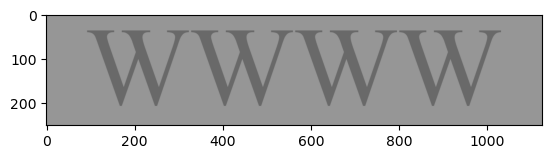

In [5]:
def draw_char(char, typeface, size):
    # Set canvas size
    W, H = (int(size * 1.5) * 3, size)
    # Set font
    font = ImageFont.truetype(typeface, size)
    # Make empty image
    img = Image.new('RGB', (W, H), color='#969696')
    # Draw text to image
    draw = ImageDraw.Draw(img)
    _, _, w, h = font.getbbox(char)
    draw.text(((W-w)/2,(H-h)/2-size/8), char, fill='#696969', font=font)

    return np.asarray(img)

img = draw_char("W" * 4, '../inputs/times.ttf', 250)
plt.imshow(img)
plt.show()

In [8]:
# Get list possible character
chars = list(string.digits + string.ascii_letters)

for index, pdfpath in tqdm(docs):
    # Open file
    pdf = fitz.open(pdfpath)

    # Get all fonts across document
    fonts = list({el for i in range(pdf.page_count) for el in pdf.get_page_fonts(i)})
    embedded_fonts = []

    # Loop through fonts
    for font in fonts:
        # Extract font
        name, ext, _, content = pdf.extract_font(font[0])
        name = name.split('+')[-1]

        # If font is embedded
        if ext == 'ttf' and "TNR" in name:
            # Write fonts
            filename = hashlib.md5(name.encode('utf-8')).hexdigest() + "." + ext
            f = open("../fonts/" + filename, "wb")
            f.write(content)
            f.close()

            # Append to array
            embedded_fonts.append((filename, name))

    # Setup problematic font map
    hashmap = {}
    setmap = set(swaps[index].keys())

    # Counter
    y_true = []
    y_pred = []

    # Loop through embedded fonts
    for fontfile, fontname in embedded_fonts:
        hashmap[fontname] = set()
        # Loop through characters
        for char in chars:
            # Render characters
            img = draw_char(char * 4, '../fonts/' + fontfile, 250)
            # Detect characters with OCR
            result = reader.readtext(img, allowlist=chars)

            # If character detected
            if len(result) > 0:
                # Calculate most character appear
                most_char, total = collections.Counter(result[0][1]).most_common(1)[0]
                # If char not the same
                if most_char.lower() == char.lower():
                    if char not in setmap or swaps[index][char] == char:
                        # True Negative
                        y_true.append('Real')
                        y_pred.append('Real')
                    else:
                        # False Negative
                        y_true.append('Fake')
                        y_pred.append('Real')
                        print(char)
                else:
                    # Add to hash map
                    hashmap[fontname].add(char)

                    # Print char
                    if char not in setmap:
                        # False Positive
                        y_true.append('Real')
                        y_pred.append('Fake')
                        print(char)
                    else:
                        # True Positive
                        y_true.append('Fake')
                        y_pred.append('Fake')

                # Char in font not embedded
            elif char not in setmap or swaps[index][char] == char:
                # True Negative
                y_true.append('Real')
                y_pred.append('Real')
            elif char in setmap:
                hashmap[fontname].add(char)
                # True Positive
                y_true.append('Fake')
                y_pred.append('Fake')

        if len(hashmap[fontname]) == 0:
            del hashmap[fontname]

    cm = confusion_matrix(y_true, y_pred)
    if not np.array_equal(cm, [[4,0],[0,58]]):
        print("File :", os.path.basename(pdfpath))
        print("Accuracy Score :", accuracy_score(y_true, y_pred))
        print("Precision Score :", precision_score(y_true, y_pred, pos_label='Fake'))
        print("Recall Score :", recall_score(y_true, y_pred, pos_label='Fake'))
        print("F1 Score :", f1_score(y_true, y_pred, pos_label='Fake'))
        ConfusionMatrixDisplay.from_predictions(y_true, y_pred, cmap='gray')
        plt.show()
    else:
        print("File :", os.path.basename(pdfpath))
        print("Accuracy Score :", accuracy_score(y_true, y_pred))

  7%|▋         | 1/14 [00:03<00:44,  3.41s/it]

File : 1 data_penelitian - ichlalsul bulqiah.pdf
Accuracy Score : 1.0


 14%|█▍        | 2/14 [00:06<00:37,  3.15s/it]

File : 1 Kesimpulan Dan Isu Isu - RIKA PURNAWATI.pdf
Accuracy Score : 1.0


 21%|██▏       | 3/14 [00:09<00:33,  3.03s/it]

File : 1 Pendahuluan - TUNGGUL WIDO.pdf
Accuracy Score : 1.0


 29%|██▊       | 4/14 [00:12<00:30,  3.08s/it]

File : 1 Perceptron merupdkdn moael seaerhdnd adri jdringdn - Muhammad Syukur Abadi.pdf
Accuracy Score : 1.0


 36%|███▌      | 5/14 [00:15<00:27,  3.02s/it]

File : 1 Survey Saddam - MERCYANO DANDI HIDAYAT.pdf
Accuracy Score : 1.0


 43%|████▎     | 6/14 [00:18<00:23,  2.97s/it]

File : 1 Tugas TBL - Adika Prana Ihsanuddin.pdf
Accuracy Score : 1.0


 50%|█████     | 7/14 [00:21<00:20,  2.98s/it]

File : 2 data_penelitian2 - ichlalsul bulqiah.pdf
Accuracy Score : 1.0


 57%|█████▋    | 8/14 [00:24<00:18,  3.03s/it]

File : 2 Saddam - Jaka Asa Baldan Ahmad.pdf
Accuracy Score : 1.0


 64%|██████▍   | 9/14 [00:27<00:14,  2.99s/it]

File : 3 data_penelitian3 - ichlalsul bulqiah.pdf
Accuracy Score : 1.0


 71%|███████▏  | 10/14 [00:30<00:12,  3.00s/it]

File : 3 Fake TNR 3 - Nor Mohammad Anwar Sadad.pdf
Accuracy Score : 1.0


 79%|███████▊  | 11/14 [00:33<00:09,  3.02s/it]

File : 3 Isi_Form - Mochammad Firman Maulidiansyah.pdf
Accuracy Score : 1.0


 86%|████████▌ | 12/14 [00:36<00:06,  3.01s/it]

File : 3 Test - Arief Husnan.pdf
Accuracy Score : 1.0


 93%|█████████▎| 13/14 [00:39<00:02,  3.00s/it]

File : 4 data_penelitian4 - ichlalsul bulqiah.pdf
Accuracy Score : 1.0


100%|██████████| 14/14 [00:42<00:00,  3.01s/it]

File : 4 Fake TNR Font 4 - Nur Wahyu Melliano Hariyanto.pdf
Accuracy Score : 1.0


# Just extract font

In [12]:
for index, pdfpath in tqdm(docs):
    # Open file
    pdf = fitz.open(pdfpath)

    # Get all fonts across document
    fonts = list({el for i in range(pdf.page_count) for el in pdf.get_page_fonts(i)})
    embedded_fonts = []

    # Loop through fonts
    for font in fonts:
        # Extract font
        name, ext, _, content = pdf.extract_font(font[0])
        name = name.split('+')[-1]

        # If font is embedded
        if ext == 'ttf' and "TNR" in name:
            # Write fonts
            filename = os.path.basename(pdfpath) + " -- " + name + " -- " + str(font[0]) + "." + ext
            f = open("../fonts/" + filename, "wb")
            f.write(content)
            f.close()

    pdf.close()


100%|██████████| 14/14 [00:00<00:00, 200.05it/s]
